Week 5 Notebook: Building a Deep Learning Model
===============================================================

Now, we'll look at a deep learning model based on low-level track features.

In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

In [2]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

## Data Generators

A quick aside on data generators. As training on large datasets is a key component of many deep learning approaches (and especially in high energy physics), and these datasets no longer fit in memory, it is imporatant to write a data generator which can automatically fetch data.

Here we modify one from: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [3]:
from DataGenerator import DataGenerator
help(DataGenerator)

Help on class DataGenerator in module DataGenerator:

class DataGenerator(tensorflow.python.keras.utils.data_utils.Sequence)
 |  DataGenerator(list_files, features, labels, spectators, batch_size=1024, n_dim=60, remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False, max_entry=20000, scale_mass_pt=[1, 1])
 |  
 |  Generates data for Keras
 |  
 |  Method resolution order:
 |      DataGenerator
 |      tensorflow.python.keras.utils.data_utils.Sequence
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Generate one batch of data
 |  
 |  __init__(self, list_files, features, labels, spectators, batch_size=1024, n_dim=60, remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False, max_entry=20000, scale_mass_pt=[1, 1])
 |      Initialization
 |  
 |  __len__(self)
 |      Denotes the number of batches per epoch
 |  
 |  on_epoch_end(self)
 |      Updates indexes after each epoch
 |  
 |  -------------------

In [4]:
# load training and validation generators 
# train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
# val_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']

train_files=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
val_files=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_11.root"]


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=5000)

val_generator = DataGenerator(val_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=5000)

## Test Data Generator
Note that the track array has a different "shape." There are also slightly less than the requested `batch_size=1024` because we remove unlabeled samples.

In [5]:
X, y = train_generator[0]
print(X.shape)
print(y.shape)

(943, 60, 48)
(943, 2)


Note this generator can be optimized further (storing the data file locally, etc.). It's important to note that I/O is often a bottleneck for training big networks.

## Fully Connected Neural Network Classifier

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda
import tensorflow.keras.backend as K

# define dense keras model
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Flatten(name='flatten_1')(x)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model_dense = Model(inputs=inputs, outputs=outputs)
keras_model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_dense.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                184384    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                

In [8]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_dense_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_dense = keras_model_dense.fit_generator(train_generator, 
                                                validation_data = val_generator, 
                                                steps_per_epoch=len(train_generator), 
                                                validation_steps=len(val_generator),
                                                max_queue_size=5,
                                                epochs=100, 
                                                shuffle=False,
                                                callbacks = callbacks, 
                                                verbose=0)
# reload best weights
keras_model_dense.load_weights('keras_model_dense_best.h5')

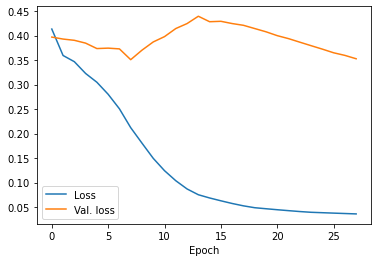

In [9]:
plt.figure()
plt.plot(history_dense.history['loss'],label='Loss')
plt.plot(history_dense.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Deep Sets Classifier

This model uses the `Conv1D` layer of Keras, but really it's more like the Deep Sets architecture applied to jets, the so-caled Particle-flow network approach{cite}`Komiske:2018cqr,NIPS2017_6931`.
By using a kernel size of 1, we are applying the same fully connected neural network to each track. 
Then the `Lambda` layer sums over the tracks (actually it takes the mean). 

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda, GlobalAveragePooling1D
import tensorflow.keras.backend as K

# define Deep Sets model with Conv1D Keras layer
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv1D(64, 1, strides=1, padding='same', name = 'conv1d_1', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_2', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_3', activation='relu')(x)
# sum over tracks
x = GlobalAveragePooling1D(name='pool_1')(x)
x = Dense(100, name = 'dense_1', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model_conv1d = Model(inputs=inputs, outputs=outputs)
keras_model_conv1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_conv1d.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            3136      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 32)            2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 32)            1056      
_________________________________________________________________
pool_1 (GlobalAveragePooling (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [11]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_conv1d_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_conv1d = keras_model_conv1d.fit(train_generator, 
                                        validation_data = val_generator, 
                                        steps_per_epoch=len(train_generator), 
                                        validation_steps=len(val_generator),
                                        max_queue_size=5,
                                        epochs=100, 
                                        shuffle=False,
                                        callbacks = callbacks, 
                                        verbose=0)
# reload best weights
keras_model_conv1d.load_weights('keras_model_conv1d_best.h5')

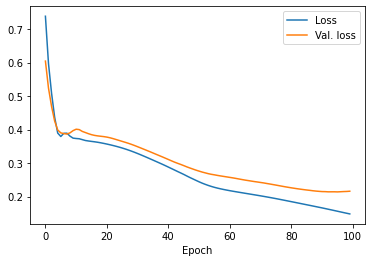

In [12]:
plt.figure()
plt.plot(history_conv1d.history['loss'],label='Loss')
plt.plot(history_conv1d.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
# load testing file
# test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']
test_files=["/teams/DSC180A_FA20_A00/b06particlephysics/test/ntuple_merged_0.root"]
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True)

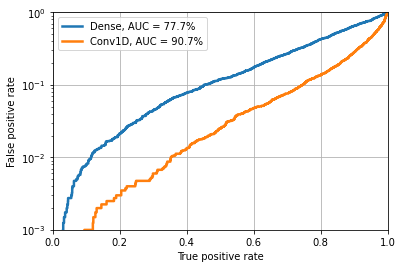

In [15]:
# run model inference on test data set
predict_array_dnn = []
predict_array_cnn = []
label_array_test = []

for t in test_generator:
    label_array_test.append(t[1])
    predict_array_dnn.append(keras_model_dense.predict(t[0]))
    predict_array_cnn.append(keras_model_conv1d.predict(t[0]))
    
    
predict_array_dnn = np.concatenate(predict_array_dnn,axis=0)
predict_array_cnn = np.concatenate(predict_array_cnn,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)


# create ROC curves
fpr_dnn, tpr_dnn, threshold_dnn = roc_curve(label_array_test[:,1], predict_array_dnn[:,1])
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(label_array_test[:,1], predict_array_cnn[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_dnn, fpr_dnn, lw=2.5, label="Dense, AUC = {:.1f}%".format(auc(fpr_dnn,tpr_dnn)*100))
plt.plot(tpr_cnn, fpr_cnn, lw=2.5, label="Conv1D, AUC = {:.1f}%".format(auc(fpr_cnn,tpr_cnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

We see the more structurally-aware Conv1D/Deep Sets model does better than a simple fully conneted neural network appraoch.

<hr>

## Task

Create a baseline deep learning model with PF candidate, track, and/or secondary vertex features. The choice of input embedding and classifier is up to you. (Note: you do not need to implement the interaction network here).

In [62]:
from tensorflow.keras.layers import MaxPooling1D,GlobalMaxPooling1D,Flatten

In [63]:
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv1D(128, 4, strides=1, padding='same', name = 'conv1d_1', activation='relu')(x)
x = Conv1D(64, 4, strides=1, padding='same', name = 'conv1d_2', activation='relu')(x)
x = MaxPooling1D(name='pool_1')(x)

x = Conv1D(64, 4, strides=1, padding='same', name = 'conv1d_3', activation='relu')(x)
x = Conv1D(64, 4, strides=1, padding='same', name = 'conv1d_4', activation='relu')(x)
x = MaxPooling1D(name='pool_2')(x)

x = Flatten(name='flatten_1')(x)
x = Dense(256, name = 'dense_2', activation='relu')(x)
x = Dense(256, name = 'dense_3', activation='relu')(x)

outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
m = Model(inputs=inputs, outputs=outputs)
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(m.summary())

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 128)           24704     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 64)            32832     
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 30, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 64)            16448     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 64)          

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('m_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_m = m.fit(train_generator, 
                  validation_data = val_generator, 
                  steps_per_epoch=len(train_generator), 
                  validation_steps=len(val_generator),
                  max_queue_size=5,
                  epochs=50, 
                  shuffle=False,
                  callbacks = callbacks, 
                  verbose=1)
# reload best weights
m.load_weights('m_best.h5')

Epoch 1/50
4/4 [==============================] - 13s 3s/step - loss: 0.5051 - accuracy: 0.7368 - val_loss: 0.5032 - val_accuracy: 0.8729
Epoch 2/50
4/4 [==============================] - 10s 3s/step - loss: 0.3903 - accuracy: 0.8715 - val_loss: 0.4150 - val_accuracy: 0.8729
Epoch 3/50
4/4 [==============================] - 12s 3s/step - loss: 0.3704 - accuracy: 0.8715 - val_loss: 0.4006 - val_accuracy: 0.8729
Epoch 4/50
4/4 [==============================] - 12s 3s/step - loss: 0.3501 - accuracy: 0.8715 - val_loss: 0.3867 - val_accuracy: 0.8729
Epoch 5/50
4/4 [==============================] - 12s 3s/step - loss: 0.3315 - accuracy: 0.8715 - val_loss: 0.3894 - val_accuracy: 0.8729
Epoch 6/50
4/4 [==============================] - 12s 3s/step - loss: 0.3069 - accuracy: 0.8715 - val_loss: 0.3890 - val_accuracy: 0.8729
Epoch 7/50
4/4 [==============================] - 12s 3s/step - loss: 0.2786 - accuracy: 0.8715 - val_loss: 0.3585 - val_accuracy: 0.8729
Epoch 8/50
4/4 [==================

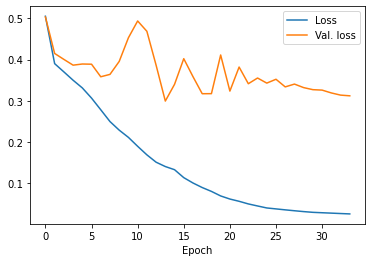

In [66]:
plt.figure()
plt.plot(history_m.history['loss'],label='Loss')
plt.plot(history_m.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

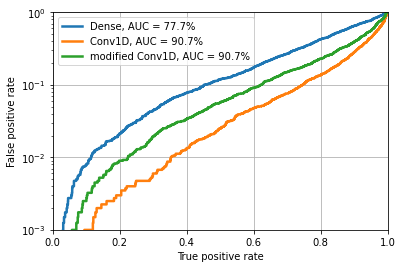

In [67]:
predict_array_m = []
label_array_test = []

for t in test_generator:
    label_array_test.append(t[1])
    predict_array_m.append(m.predict(t[0]))
    
    
predict_array_m = np.concatenate(predict_array_m,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)


# create ROC curves
fpr_m, tpr_m, threshold_m = roc_curve(label_array_test[:,1], predict_array_m[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_dnn, fpr_dnn, lw=2.5, label="Dense, AUC = {:.1f}%".format(auc(fpr_dnn,tpr_dnn)*100))
plt.plot(tpr_cnn, fpr_cnn, lw=2.5, label="Conv1D, AUC = {:.1f}%".format(auc(fpr_cnn,tpr_cnn)*100))
plt.plot(tpr_m, fpr_m, lw=2.5, label="modified Conv1D, AUC = {:.1f}%".format(auc(fpr_cnn,tpr_cnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()